正在分析: 0002.png ...
偵測到 3 個文字區塊。

--- 分類結果 ---
區塊 0: 高度 26.0 -> Rank 2
區塊 1: 高度 28.0 -> Rank 1
區塊 2: 高度 37.0 -> Rank 0


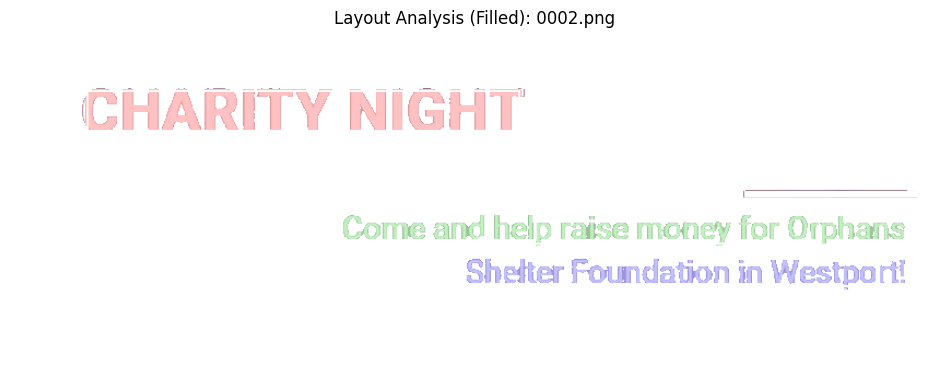

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from paddleocr import PaddleOCR
from sklearn.cluster import KMeans
import os
import logging

# 設定 logging 級別，避免雜訊
logging.getLogger("ppocr").setLevel(logging.WARNING)

def preprocess_transparent_image(image_path):
    """
    讀取 RGBA 圖片，並將透明背景處理成純白色。
    """
    img_rgba = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    
    if img_rgba is None:
        raise FileNotFoundError(f"找不到圖片: {image_path}")

    if img_rgba.shape[2] == 4:
        b, g, r, a = cv2.split(img_rgba)
        foreground = cv2.merge((b, g, r))
        alpha_mask = a.astype(float) / 255.0
        alpha_mask = np.stack([alpha_mask]*3, axis=-1)
        white_bg = np.ones_like(foreground, dtype=float) * 255.0
        blended = (foreground.astype(float) * alpha_mask) + (white_bg * (1.0 - alpha_mask))
        img_ocr_ready = blended.astype(np.uint8)
    else:
        img_rgba = cv2.cvtColor(img_rgba, cv2.COLOR_BGR2BGRA)
        img_ocr_ready = img_rgba[:,:,:3]

    return img_rgba, img_ocr_ready

def classify_text_layout(image_path, n_clusters=3, alpha_transparency=0.4):
    """
    alpha_transparency: 填充顏色的透明度 (0.0 完全透明 ~ 1.0 完全不透明)，建議 0.3~0.5
    """
    # 1. 圖片前處理
    try:
        img_display, img_for_ocr = preprocess_transparent_image(image_path)
    except FileNotFoundError as e:
        print(e)
        return

    # 2. 初始化 PaddleOCR (只偵測)
    ocr = PaddleOCR(use_angle_cls=False, lang='ch', show_log=False) 
    
    print(f"正在分析: {os.path.basename(image_path)} ...")
    
    # 呼叫底層偵測器避開 Bug
    dt_boxes, _ = ocr.text_detector(img_for_ocr)
    
    if dt_boxes is None or len(dt_boxes) == 0:
        print("未偵測到任何文字區塊。")
        return
        
    boxes = list(dt_boxes)
    print(f"偵測到 {len(boxes)} 個文字區塊。")

    # 3. 提取特徵 (高度)
    features = []
    box_heights = []
    for box in boxes:
        box = np.array(box).astype(np.float32)
        height_left = np.linalg.norm(box[0] - box[3])
        height_right = np.linalg.norm(box[1] - box[2])
        avg_height = (height_left + height_right) / 2
        features.append([avg_height])
        box_heights.append(avg_height)

    # 4. K-Means 分群
    actual_n_clusters = min(n_clusters, len(boxes))
    if actual_n_clusters < 2:
        labels = [0] * len(boxes)
        actual_n_clusters = 1
    else:
        X = np.array(features)
        kmeans = KMeans(n_clusters=actual_n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)

    # 排序：高度大 -> Rank 0
    cluster_avg_height = {}
    for i in range(actual_n_clusters):
        cluster_mask = (labels == i)
        if np.any(cluster_mask):
            cluster_avg_height[i] = np.mean(np.array(features)[cluster_mask])
        else:
            cluster_avg_height[i] = 0
    sorted_indices = sorted(cluster_avg_height, key=cluster_avg_height.get, reverse=True)
    rank_map = {old_id: new_rank for new_rank, old_id in enumerate(sorted_indices)}
    
    # ==========================================
    # 5. 視覺化 (修改為半透明填充)
    # ==========================================
    # 準備底圖 (Matplotlib 顯示用 RGBA)
    img_final_show = cv2.cvtColor(img_display, cv2.COLOR_BGRA2RGBA)
    
    # [新增] 建立一個圖層 (overlay) 用來畫實心填充，先複製原圖
    overlay = img_final_show.copy()
    
    colors = [
        (255, 0, 0),    # Rank 0 (紅 - 最大)
        (0, 200, 0),    # Rank 1 (綠 - 中等)
        (0, 0, 255),    # Rank 2 (藍 - 最小)
        (255, 200, 0),  # 黃
        (0, 200, 255)   # 青
    ]
    
    print("\n--- 分類結果 ---")
    for idx, box in enumerate(boxes):
        # 確保 box 是整數型態，fillPoly 需要整數
        box = np.array(box).astype(np.int32)
        
        rank = rank_map[labels[idx]]
        h = box_heights[idx]
        
        print(f"區塊 {idx}: 高度 {h:.1f} -> Rank {rank}")
        
        # 選擇顏色
        color = colors[rank % len(colors)]
        
        # [修改] 使用 fillPoly 填充實心多邊形到 overlay 圖層上
        cv2.fillPoly(overlay, [box], color=color)
        
        # [選擇性] 為了讓邊界更清晰，還是可以畫一個細細的外框線 (畫在最終底圖上)
        cv2.polylines(img_final_show, [box], isClosed=True, color=color, thickness=2)
        
        # 標註文字 (畫在最終底圖上，確保文字最清晰)
        text_loc = (max(0, box[0][0]), max(0, box[0][1]-5))
        cv2.putText(img_final_show, f"L{rank}", text_loc, 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # [新增] 關鍵步驟：將填滿顏色的 overlay 與原圖進行半透明混合
    # addWeighted 公式: Output = src1 * alpha + src2 * beta + gamma
    # 這裡: 最終圖 = overlay * 透明度 + 原圖 * (1-透明度)
    img_final_show = cv2.addWeighted(overlay, alpha_transparency, img_final_show, 1 - alpha_transparency, 0)

    plt.figure(figsize=(12, 12))
    plt.imshow(img_final_show)
    plt.axis('off')
    plt.title(f"Layout Analysis (Filled): {os.path.basename(image_path)}")
    plt.show()

# --- 執行區塊 ---
image_path = 'test_result_default/5888a2a095a7a863ddcc1ca2/0002.png' # 替換成你的圖片路徑

if os.path.exists(image_path):
    # 你可以調整 alpha_transparency 來改變透明度 (例如 0.3 更透明, 0.7 更不透明)
    classify_text_layout(image_path, n_clusters=3, alpha_transparency=0.4)
else:
    print(f"找不到檔案: {image_path}")

正在分析 (黑底模式): 0003.png ...
偵測到 8 個文字區塊。

--- 分類結果 ---
區塊 0: 高度 22.0 -> Rank 2
區塊 1: 高度 22.0 -> Rank 2
區塊 2: 高度 47.0 -> Rank 1
區塊 3: 高度 32.0 -> Rank 1
區塊 4: 高度 36.0 -> Rank 1
區塊 5: 高度 227.0 -> Rank 0
區塊 6: 高度 40.0 -> Rank 1
區塊 7: 高度 40.5 -> Rank 1


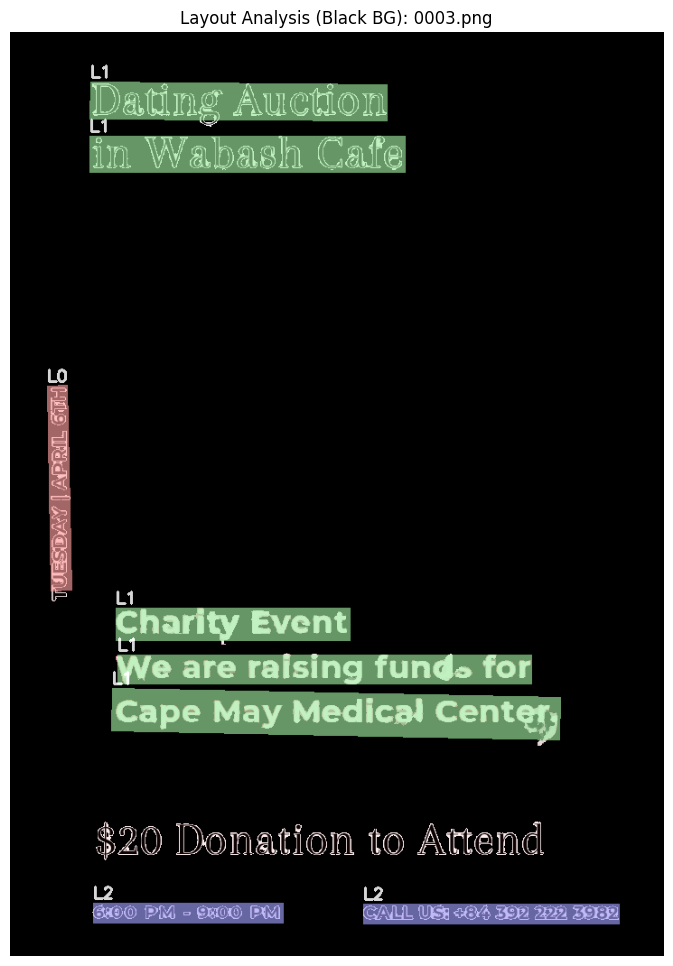

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from paddleocr import PaddleOCR
from sklearn.cluster import KMeans
import os
import logging

# 關閉 PaddleOCR 的 Debug log
logging.getLogger("ppocr").setLevel(logging.WARNING)

def preprocess_transparent_image(image_path, bg_color='black'):
    """
    讀取 RGBA 圖片，並將透明背景處理成指定顏色。
    bg_color: 'black' (黑底，適合淺色字) 或 'white' (白底，適合深色字)
    """
    img_rgba = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    
    if img_rgba is None:
        raise FileNotFoundError(f"找不到圖片: {image_path}")

    if img_rgba.shape[2] == 4:
        b, g, r, a = cv2.split(img_rgba)
        foreground = cv2.merge((b, g, r))
        
        # Alpha 轉為 0.0 ~ 1.0
        alpha_mask = a.astype(float) / 255.0
        alpha_mask = np.stack([alpha_mask]*3, axis=-1)
        
        # --- [關鍵修改] 設定背景顏色 ---
        if bg_color == 'black':
            # 全黑背景 (0, 0, 0)
            background = np.zeros_like(foreground, dtype=float)
        else:
            # 全白背景 (255, 255, 255)
            background = np.ones_like(foreground, dtype=float) * 255.0
            
        # 混合前景與背景
        blended = (foreground.astype(float) * alpha_mask) + (background * (1.0 - alpha_mask))
        img_ocr_ready = blended.astype(np.uint8)
    else:
        # 如果本來就沒透明度，轉一下格式就好
        img_rgba = cv2.cvtColor(img_rgba, cv2.COLOR_BGR2BGRA)
        img_ocr_ready = img_rgba[:,:,:3]

    return img_rgba, img_ocr_ready

def classify_text_layout(image_path, n_clusters=3, alpha_transparency=0.4):
    # 1. 圖片前處理 (這裡指定用黑底)
    try:
        # [修改] 這裡傳入 bg_color='black'
        img_display, img_for_ocr = preprocess_transparent_image(image_path, bg_color='black')
    except FileNotFoundError as e:
        print(e)
        return

    # 2. 初始化 PaddleOCR
    ocr = PaddleOCR(use_angle_cls=False, lang='ch', show_log=False) 
    
    print(f"正在分析 (黑底模式): {os.path.basename(image_path)} ...")
    
    # 使用 text_detector 避開 Bug
    dt_boxes, _ = ocr.text_detector(img_for_ocr)
    
    if dt_boxes is None or len(dt_boxes) == 0:
        print("未偵測到任何文字區塊。")
        # 顯示處理後的黑底圖，讓你看看是不是字還是不清楚
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(img_for_ocr, cv2.COLOR_BGR2RGB))
        plt.title("Preprocessed Image (Black BG)")
        plt.show()
        return
        
    boxes = list(dt_boxes)
    print(f"偵測到 {len(boxes)} 個文字區塊。")

    # 3. 提取特徵
    features = []
    box_heights = []
    for box in boxes:
        box = np.array(box).astype(np.float32)
        h = (np.linalg.norm(box[0]-box[3]) + np.linalg.norm(box[1]-box[2])) / 2
        features.append([h])
        box_heights.append(h)

    # 4. K-Means 分群
    actual_n_clusters = min(n_clusters, len(boxes))
    if actual_n_clusters < 2:
        labels = [0] * len(boxes)
        actual_n_clusters = 1
    else:
        kmeans = KMeans(n_clusters=actual_n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(np.array(features))

    # 排序 Rank
    cluster_avg_height = {}
    for i in range(actual_n_clusters):
        mask = (labels == i)
        cluster_avg_height[i] = np.mean(np.array(features)[mask]) if np.any(mask) else 0
    sorted_indices = sorted(cluster_avg_height, key=cluster_avg_height.get, reverse=True)
    rank_map = {old: new for new, old in enumerate(sorted_indices)}
    
    # 5. 視覺化 (半透明填充)
    # 為了顯示漂亮，我們還是用原本帶透明度的圖來畫，或者你可以改用 img_for_ocr 來看黑底效果
    # 這裡示範用「黑底處理後的圖」來顯示，這樣你看得最清楚 OCR 看到了什麼
    img_final_show = cv2.cvtColor(img_for_ocr, cv2.COLOR_BGR2RGBA) # 用黑底圖做底
    overlay = img_final_show.copy()
    
    colors = [(255, 0, 0), (0, 200, 0), (0, 0, 255), (255, 200, 0), (0, 200, 255)]
    
    print("\n--- 分類結果 ---")
    for idx, box in enumerate(boxes):
        box = np.array(box).astype(np.int32)
        rank = rank_map[labels[idx]]
        
        print(f"區塊 {idx}: 高度 {box_heights[idx]:.1f} -> Rank {rank}")
        
        color = colors[rank % len(colors)]
        cv2.fillPoly(overlay, [box], color=color)
        cv2.putText(img_final_show, f"L{rank}", (box[0][0], box[0][1]-5), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2) # 文字改白色以免在黑底看不見

    img_final_show = cv2.addWeighted(overlay, alpha_transparency, img_final_show, 1 - alpha_transparency, 0)

    plt.figure(figsize=(12, 12))
    plt.imshow(img_final_show)
    plt.axis('off')
    plt.title(f"Layout Analysis (Black BG): {os.path.basename(image_path)}")
    plt.show()

# --- 執行 ---
image_path = 'test_result_default/5888b73695a7a863ddcc1dad/0003.png'

if os.path.exists(image_path):
    classify_text_layout(image_path, n_clusters=3, alpha_transparency=0.4)
else:
    print(f"找不到檔案: {image_path}")

正在偵測: 0003.png ...
偵測到 8 個區塊，準備裁切...
已儲存: 001.png (大小: 349x63)
已儲存: 002.png (大小: 369x60)
已儲存: 003.png (大小: 47x248)
已儲存: 004.png (大小: 279x56)
已儲存: 005.png (大小: 478x52)
已儲存: 006.png (大小: 517x77)
已儲存: 007.png (大小: 230x42)
已儲存: 008.png (大小: 303x42)

全部完成！請查看資料夾: output_crops/


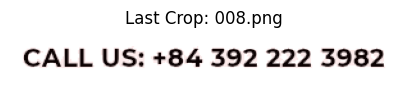

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from paddleocr import PaddleOCR
import os
import shutil # 用來清理舊資料夾

def preprocess_for_detection(img_rgba, bg_color='black'):
    """
    將 RGBA 轉為不透明背景圖片 (僅用於讓模型偵測位置)
    """
    b, g, r, a = cv2.split(img_rgba)
    foreground = cv2.merge((b, g, r))
    alpha_mask = a.astype(float) / 255.0
    alpha_mask = np.stack([alpha_mask]*3, axis=-1)
    
    if bg_color == 'black':
        background = np.zeros_like(foreground, dtype=float)
    else:
        background = np.ones_like(foreground, dtype=float) * 255.0
        
    blended = (foreground.astype(float) * alpha_mask) + (background * (1.0 - alpha_mask))
    return blended.astype(np.uint8)

def crop_and_save_text(image_path, output_folder='output_crops', padding=5):
    """
    padding: 裁切時往外擴張的像素 (留白)
    """
    # 1. 讀取原始圖片 (RGBA)
    img_original = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    
    if img_original is None:
        print(f"找不到圖片: {image_path}")
        return

    # 確保是 4 通道，如果不是，強制轉為 RGBA 以便處理
    if img_original.shape[2] == 3:
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2BGRA)
    
    # 2. 產生偵測用的圖片 (轉成黑底以凸顯淺色字)
    img_detect = preprocess_for_detection(img_original, bg_color='black')
    
    # 3. 初始化 PaddleOCR (只偵測)
    ocr = PaddleOCR(use_angle_cls=False, lang='ch', show_log=False)
    
    print(f"正在偵測: {os.path.basename(image_path)} ...")
    dt_boxes, _ = ocr.text_detector(img_detect)
    
    if dt_boxes is None or len(dt_boxes) == 0:
        print("未偵測到任何文字區塊。")
        return

    boxes = list(dt_boxes)
    print(f"偵測到 {len(boxes)} 個區塊，準備裁切...")

    # 4. 準備輸出資料夾
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder) # 清空舊的
    os.makedirs(output_folder)

    # 5. 開始裁切並存檔
    h_img, w_img, _ = img_original.shape
    
    # 我們根據 Y 軸 (由上到下) 對盒子進行排序，這樣 001 就會是上面的字
    # box[0][1] 代表左上角的 y 座標
    boxes.sort(key=lambda x: x[0][1])

    for i, box in enumerate(boxes):
        box = np.array(box).astype(np.float32)
        
        # 找出矩形範圍 (Bounding Rect)
        # 雖然 Paddle 回傳的是四點 (可能是斜的)，但裁切通常切正方形最保險
        x_min = int(np.min(box[:, 0]))
        x_max = int(np.max(box[:, 0]))
        y_min = int(np.min(box[:, 1]))
        y_max = int(np.max(box[:, 1]))
        
        # 加入 Padding (留白)，並確保不超出圖片邊界
        x_min = max(0, x_min - padding)
        x_max = min(w_img, x_max + padding)
        y_min = max(0, y_min - padding)
        y_max = min(h_img, y_max + padding)
        
        # [核心步驟] 從 "原始 RGBA 圖片" 中裁切
        # 這樣就能保留原本的透明背景和原始字色
        crop_img = img_original[y_min:y_max, x_min:x_max]
        
        # 存檔
        filename = f"{i+1:03d}.png" # 生成 001.png, 002.png...
        save_path = os.path.join(output_folder, filename)
        cv2.imwrite(save_path, crop_img)
        
        print(f"已儲存: {filename} (大小: {crop_img.shape[1]}x{crop_img.shape[0]})")

    print(f"\n全部完成！請查看資料夾: {output_folder}/")
    
    # [選擇性] 顯示最後一張裁切圖來檢查
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(crop_img, cv2.COLOR_BGRA2RGBA))
    plt.title(f"Last Crop: {filename}")
    plt.axis('off')
    plt.show()

# --- 執行 ---
image_path = 'test_result_default/5888b73695a7a863ddcc1dad/0003.png'

if os.path.exists(image_path):
    crop_and_save_text(image_path, output_folder='output_crops', padding=10)
else:
    print(f"找不到檔案: {image_path}")

正在初始化模型並偵測: 0002.png ...
偵測到 3 個區塊，正在處理...
  -> 已儲存: 001.png (427x65)
  -> 已儲存: 002.png (540x54)
  -> 已儲存: 003.png (427x52)

全部完成！檔案已存至: output_crops_final/


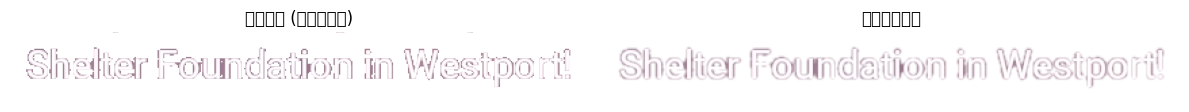

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from paddleocr import PaddleOCR
import os
import shutil
import logging

# 1. 設定 Logging 級別，避免 PaddleOCR 輸出太多雜訊
logging.getLogger("ppocr").setLevel(logging.WARNING)

def preprocess_for_detection(img_rgba, bg_color='black'):
    """
    [前處理] 將 RGBA 轉為不透明背景圖片 (僅用於讓模型偵測位置)
    bg_color: 'black' 適合偵測淺色/發光文字；'white' 適合偵測深色文字
    """
    if img_rgba is None: return None
    
    # 分離通道
    if img_rgba.shape[2] == 4:
        b, g, r, a = cv2.split(img_rgba)
        foreground = cv2.merge((b, g, r))
        alpha_mask = a.astype(float) / 255.0
        alpha_mask = np.stack([alpha_mask]*3, axis=-1)
        
        # 設定背景色
        if bg_color == 'black':
            background = np.zeros_like(foreground, dtype=float)
        else:
            background = np.ones_like(foreground, dtype=float) * 255.0
            
        # 混合
        blended = (foreground.astype(float) * alpha_mask) + (background * (1.0 - alpha_mask))
        return blended.astype(np.uint8)
    else:
        # 如果原本就不是透明圖，直接回傳
        return img_rgba[:,:,:3] if img_rgba.shape[2] == 4 else img_rgba

def clean_text_edges(img_rgba, threshold=200, kernel_size=3):
    """
    [演算法] 專門處理去背後的邊緣雜訊
    """
    if img_rgba.shape[2] != 4:
        return img_rgba 

    b, g, r, a = cv2.split(img_rgba)

    # A. Alpha 閾值切斷 (去除半透明光暈)
    # 只要透明度 < threshold (0-255) 的像素，全部強制變成透明
    _, mask_hard = cv2.threshold(a, threshold, 255, cv2.THRESH_BINARY)

    # B. 形態學開運算 (去除孤立小雜點)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    mask_cleaned = cv2.morphologyEx(mask_hard, cv2.MORPH_OPEN, kernel)

    # C. 邊緣柔化 (避免鋸齒太嚴重)
    mask_soft = cv2.GaussianBlur(mask_cleaned, (3, 3), 0)
    
    return cv2.merge((b, g, r, mask_soft))

def crop_and_process_full(image_path, output_folder='output_crops', padding=10):
    # --- 1. 讀取圖片 ---
    if not os.path.exists(image_path):
        print(f"錯誤：找不到檔案 {image_path}")
        return

    # 讀取原始 RGBA
    img_original = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    
    # 強制轉為 RGBA (如果原本是 RGB)
    if img_original.shape[2] == 3:
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2BGRA)
    
    # --- 2. 產生偵測用圖片 (黑底) ---
    # 這裡預設用 black，因為通常去背後的文字在黑底上最清楚
    img_detect = preprocess_for_detection(img_original, bg_color='black')
    
    # --- 3. 初始化 PaddleOCR (參數優化版) ---
    print(f"正在初始化模型並偵測: {os.path.basename(image_path)} ...")
    ocr = PaddleOCR(
        use_angle_cls=False, 
        lang='ch', 
        show_log=False,
        # [參數調整]
        det_limit_side_len=1280,   # 放大圖片以抓到小字
        det_db_thresh=0.2,         # 降低閾值，對模糊/淺色字更敏感
        det_db_box_thresh=0.5,     # 保留信心度較低的框
        det_db_unclip_ratio=2.2    # 讓框框胖一點，確保完整包覆筆畫
    )
    
    # 呼叫底層偵測器 (避開 v2.8 Bug)
    dt_boxes, _ = ocr.text_detector(img_detect)
    
    if dt_boxes is None or len(dt_boxes) == 0:
        print("未偵測到任何文字區塊。")
        return

    boxes = list(dt_boxes)
    print(f"偵測到 {len(boxes)} 個區塊，正在處理...")

    # --- 4. 準備輸出資料夾 ---
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder) # 清空舊資料
    os.makedirs(output_folder)

    # --- 5. 排序與裁切 ---
    h_img, w_img, _ = img_original.shape
    # 依照 Y 軸座標排序 (從上到下)
    boxes.sort(key=lambda x: x[0][1])

    for i, box in enumerate(boxes):
        box = np.array(box).astype(np.float32)
        
        # 計算邊界 (Bounding Rect)
        x_min = int(np.min(box[:, 0]))
        x_max = int(np.max(box[:, 0]))
        y_min = int(np.min(box[:, 1]))
        y_max = int(np.max(box[:, 1]))
        
        # 加入 Padding 並檢查邊界
        x_min = max(0, x_min - padding)
        x_max = min(w_img, x_max + padding)
        y_min = max(0, y_min - padding)
        y_max = min(h_img, y_max + padding)
        
        # [裁切] 從原始 RGBA 圖裁切
        crop_img = img_original[y_min:y_max, x_min:x_max]
        
        # [淨化] 清理邊緣
        # threshold=210: 代表稍微嚴格一點，切掉大部分半透明光暈
        crop_img_cleaned = clean_text_edges(crop_img, threshold=210, kernel_size=3)
        
        # [存檔]
        filename = f"{i+1:03d}.png"
        save_path = os.path.join(output_folder, filename)
        cv2.imwrite(save_path, crop_img_cleaned)
        
        print(f"  -> 已儲存: {filename} ({crop_img_cleaned.shape[1]}x{crop_img_cleaned.shape[0]})")

    print(f"\n全部完成！檔案已存至: {output_folder}/")
    
    # --- 6. 結果驗證 (顯示最後一張圖的 Before/After) ---
    if 'crop_img' in locals():
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.title("原始裁切 (可能含雜邊)")
        # 為了在 matplotlib 顯示透明圖，需轉為 RGBA 格式
        plt.imshow(cv2.cvtColor(crop_img, cv2.COLOR_BGRA2RGBA))
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("演算法淨化後")
        plt.imshow(cv2.cvtColor(crop_img_cleaned, cv2.COLOR_BGRA2RGBA))
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

# ==========================================
# 執行區塊
# ==========================================
if __name__ == "__main__":
    # 請替換成你的圖片路徑
    target_image = 'test_result_default/5888a2a095a7a863ddcc1ca2/0002.png'
    
    # padding: 裁切時往外擴張的像素
    crop_and_process_full(target_image, output_folder='output_crops_final', padding=8)